Notebook based on https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html

The data for this notebook is downloaded automatically using the PyMC package. However it can also be found here:

https://github.com/pymc-devs/pymc-examples/blob/main/examples/data/


In [1]:
import arviz as az
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
%config InlineBackend.figure_format = 'retina'
# Initialize random number generator
RANDOM_SEED = 8927
rng = np.random.default_rng(RANDOM_SEED)
az.style.use("arviz-darkgrid")

# Generating data

In [3]:
# True parameter values
alpha, sigma = 1, 1
beta = [1, 2.5]

# Size of dataset
size = 100

# Predictor variable
X1 = np.random.randn(size)
X2 = np.random.randn(size) * 0.2

# Simulate outcome variable
Y = alpha + beta[0] * X1 + beta[1] * X2 + rng.normal(size=size) * sigma

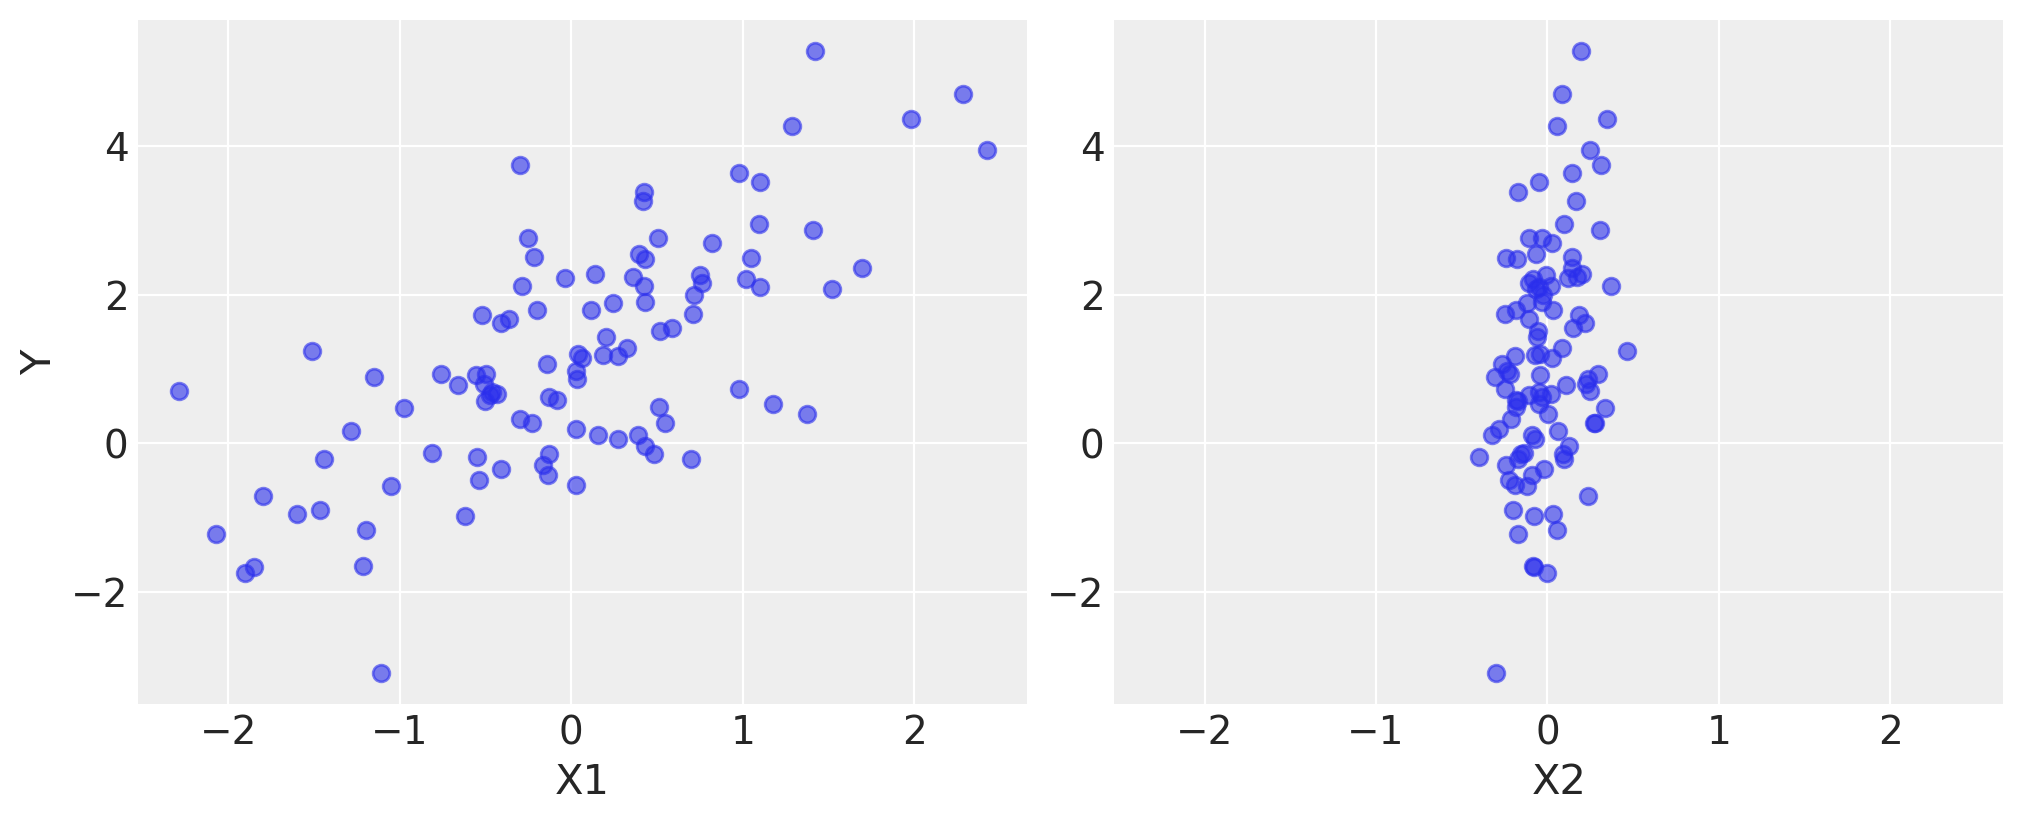

In [4]:
fig, axes = plt.subplots(1, 2, sharex=True, figsize=(10, 4))
axes[0].scatter(X1, Y, alpha=0.6)
axes[1].scatter(X2, Y, alpha=0.6)
axes[0].set_ylabel("Y")
axes[0].set_xlabel("X1")
axes[1].set_xlabel("X2");

# Model Specification

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.16.2


In [6]:
basic_model = pm.Model()

with basic_model:
    # Priors for unknown model parameters
    alpha = pm.Normal("alpha", mu=0, sigma=10)
    beta = pm.Normal("beta", mu=0, sigma=10, shape=2)
    sigma = pm.HalfNormal("sigma", sigma=1)

    # Expected value of outcome
    mu = alpha + beta[0] * X1 + beta[1] * X2

    # Likelihood (sampling distribution) of observations
    Y_obs = pm.Normal("Y_obs", mu=mu, sigma=sigma, observed=Y)

# Sampling

In [7]:
with basic_model:
    # draw 1000 posterior samples
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta, sigma]


Output()

Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 2 seconds.


In [8]:
idata

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data

In [9]:
idata.posterior["alpha"].sel(draw=slice(0, 4))

<xarray.DataArray 'alpha' (chain: 4, draw: 5)> Size: 160B
array([[1.09846193, 1.18668574, 1.18752947, 1.12545192, 1.08752088],
       [0.97502141, 1.21305674, 1.08936849, 1.08936849, 1.11719554],
       [1.08606833, 1.1367809 , 1.1177672 , 1.08641288, 1.25547836],
       [1.32182222, 1.12900318, 1.14869112, 1.08577565, 1.19988888]])
Coordinates:
  * chain    (chain) int64 32B 0 1 2 3
  * draw     (draw) int64 40B 0 1 2 3 4

If we wanted to use the slice sampling algorithm to sample our parameters instead of NUTS (which was assigned automatically), we could have specified this as the step argument for sample.

In [10]:
with basic_model:
    # instantiate sampler
    step = pm.Slice()

    # draw 5000 posterior samples
    slice_idata = pm.sample(5000, step=step)

Multiprocess sampling (4 chains in 4 jobs)
CompoundStep
>Slice: [alpha]
>Slice: [beta]
>Slice: [sigma]


Output()

Sampling 4 chains for 1_000 tune and 5_000 draw iterations (4_000 + 20_000 draws total) took 4 seconds.


# Posterior analysis

PyMC’s plotting and diagnostics functionalities are now taken care of by a dedicated, platform-agnostic package named Arviz. A simple posterior plot can be created using plot_trace.

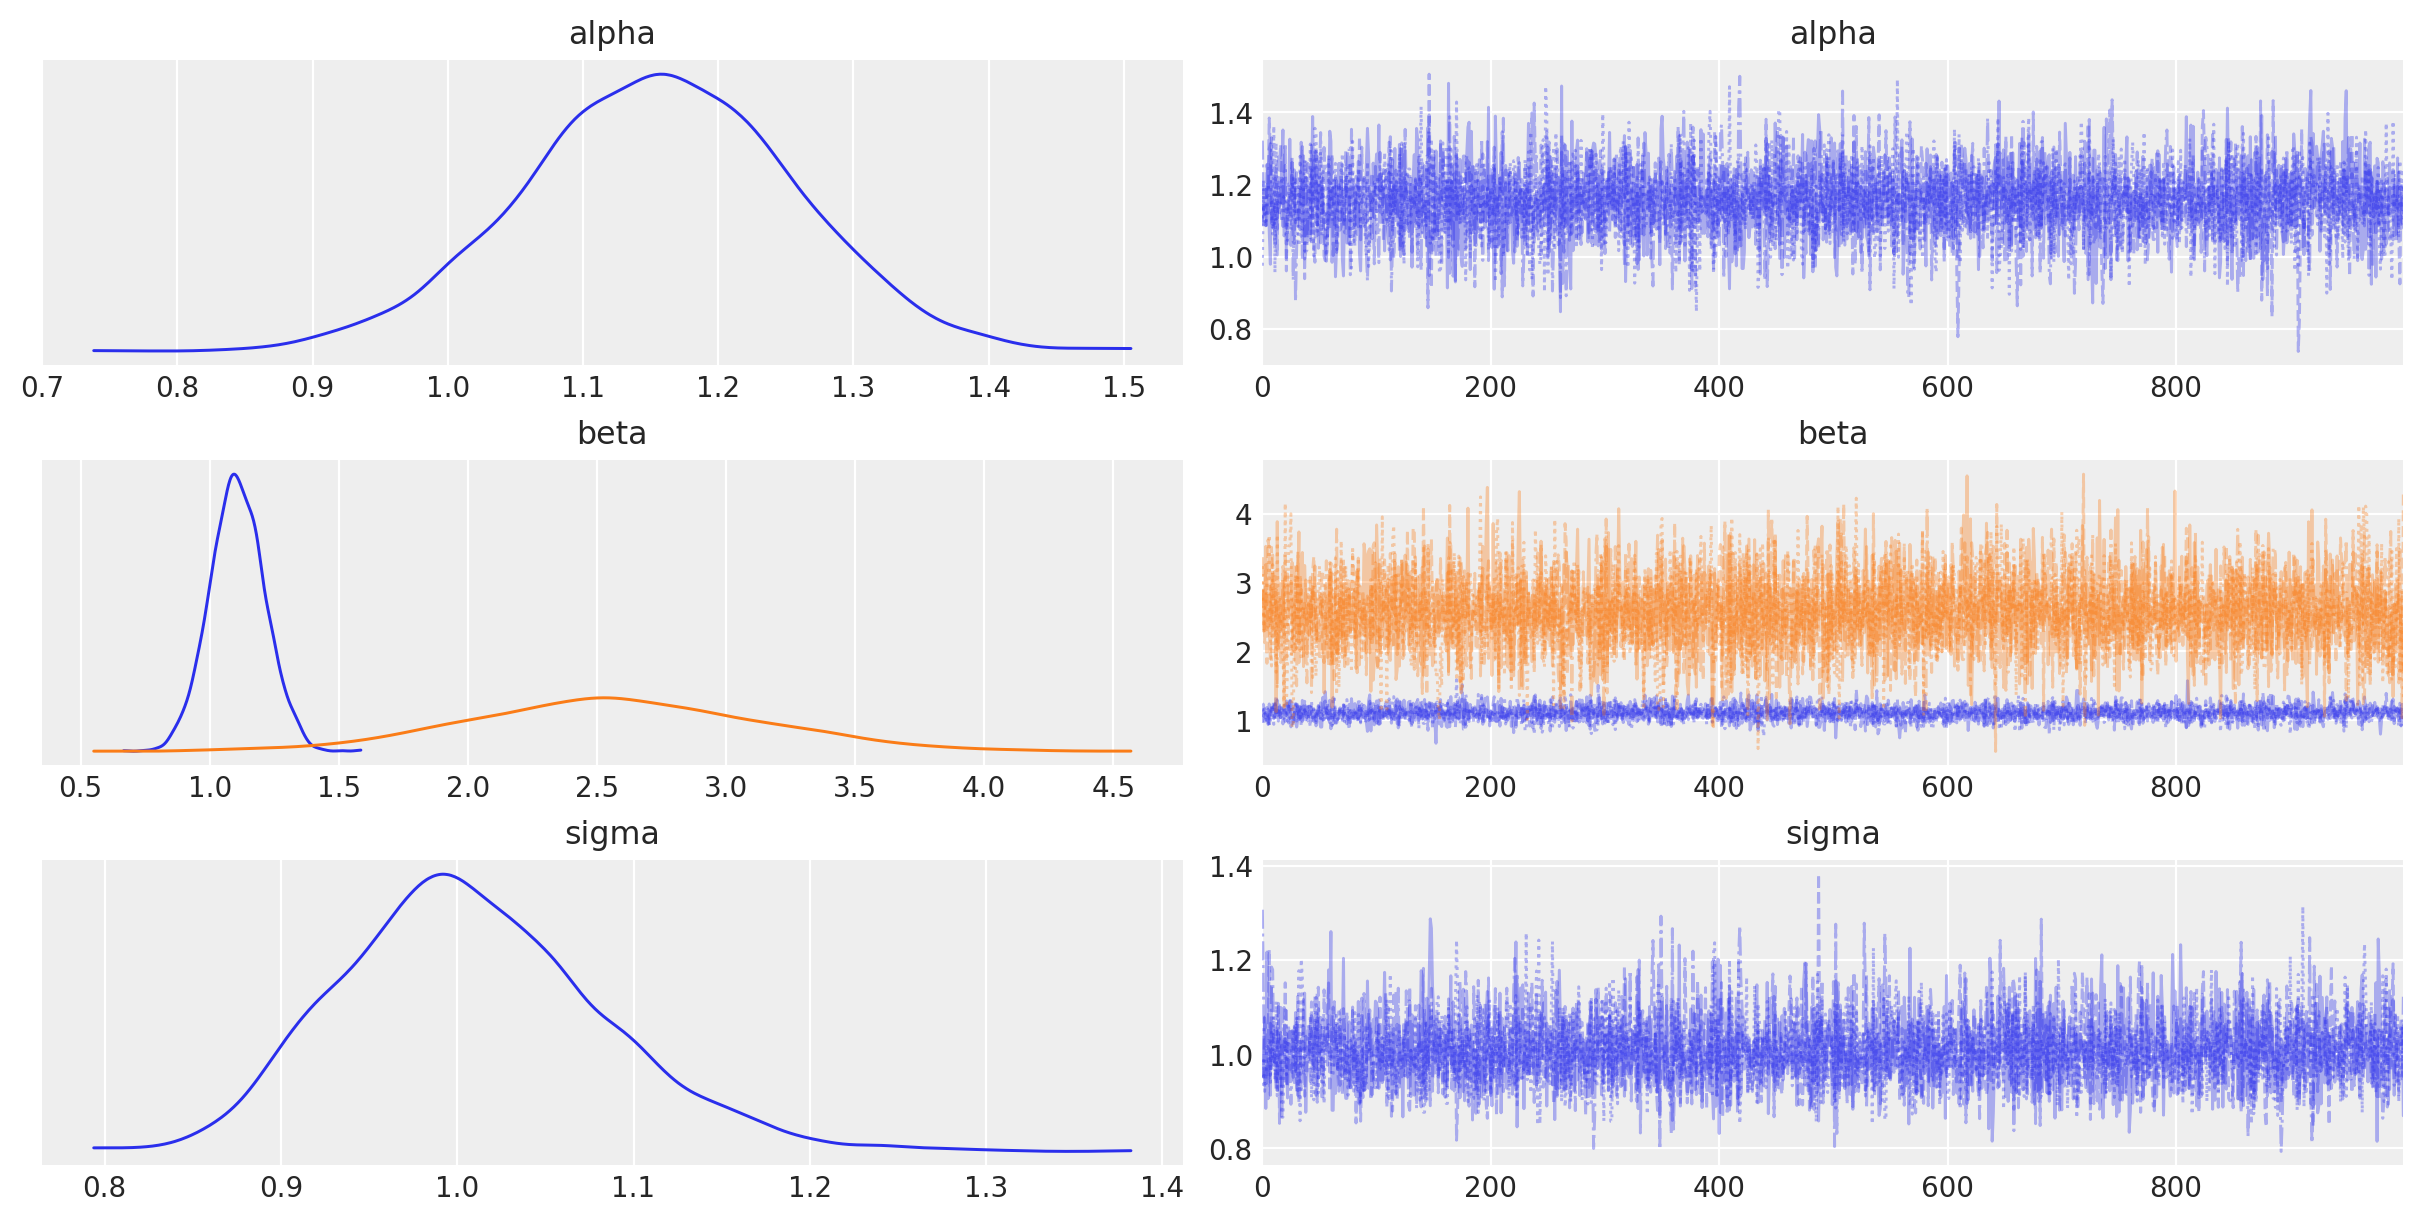

In [11]:
az.plot_trace(idata, combined=True);

The left column consists of a smoothed histogram (using kernel density estimation) of the marginal posteriors of each stochastic random variable while the right column contains the samples of the Markov chain plotted in sequential order. The beta variable, being vector-valued, produces two density plots and two trace plots, corresponding to both predictor coefficients.

In addition, the summary function provides a text-based output of common posterior statistics:

In [12]:
az.summary(idata, round_to=2)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,1.15,0.10,0.96,1.34,0.00,0.00,6113.81,3516.09,1.0
beta[0],1.11,0.11,0.90,1.30,0.00,0.00,5554.42,2841.75,1.0
beta[1],2.57,0.57,1.52,3.66,0.01,0.01,6023.40,3306.60,1.0
sigma,1.01,0.07,0.88,1.16,0.00,0.00,6021.56,3059.30,1.0


# Case study 1: Educational Outcomes for Hearing-impaired Children

As a motivating example, we will use a dataset of educational outcomes for children with hearing impairment. Here, we are interested in determining factors that are associated with better or poorer learning outcomes.

## The Data

This anonymized dataset is taken from the Listening and Spoken Language Data Repository (LSL-DR), an international data repository that tracks the demographics and longitudinal outcomes for children who have hearing loss and are enrolled in programs focused on supporting listening and spoken language development. Researchers are interested in discovering factors related to improvements in educational outcomes within these programs.



There is a suite of available predictors, including:

- gender (male)

- number of siblings in the household (siblings)

- index of family involvement (family_inv)

- whether the primary household language is not English (non_english)

- presence of a previous disability (prev_disab)

- non-white race (non_white)

- age at the time of testing (in months, age_test)

- whether hearing loss is not severe (non_severe_hl)

- whether the subject’s mother obtained a high school diploma or better (mother_hs)

- whether the hearing impairment was identified by 3 months of age (early_ident).

The outcome variable is a standardized test score in one of several learning domains.

In [13]:
test_scores = pd.read_csv(pm.get_data("test_scores.csv"), index_col=0)
test_scores.head()

,score,male,siblings,family_inv,non_english,prev_disab,age_test,non_severe_hl,mother_hs,early_ident,non_white
0,40,0,2.0,2.0,False,NaN,55,1.0,NaN,False,False
1,31,1,0.0,NaN,False,0.0,53,0.0,0.0,False,False
2,83,1,1.0,1.0,True,0.0,52,1.0,NaN,False,True
3,75,0,3.0,NaN,False,0.0,55,0.0,1.0,False,False
5,62,0,0.0,4.0,False,1.0,50,0.0,NaN,False,False


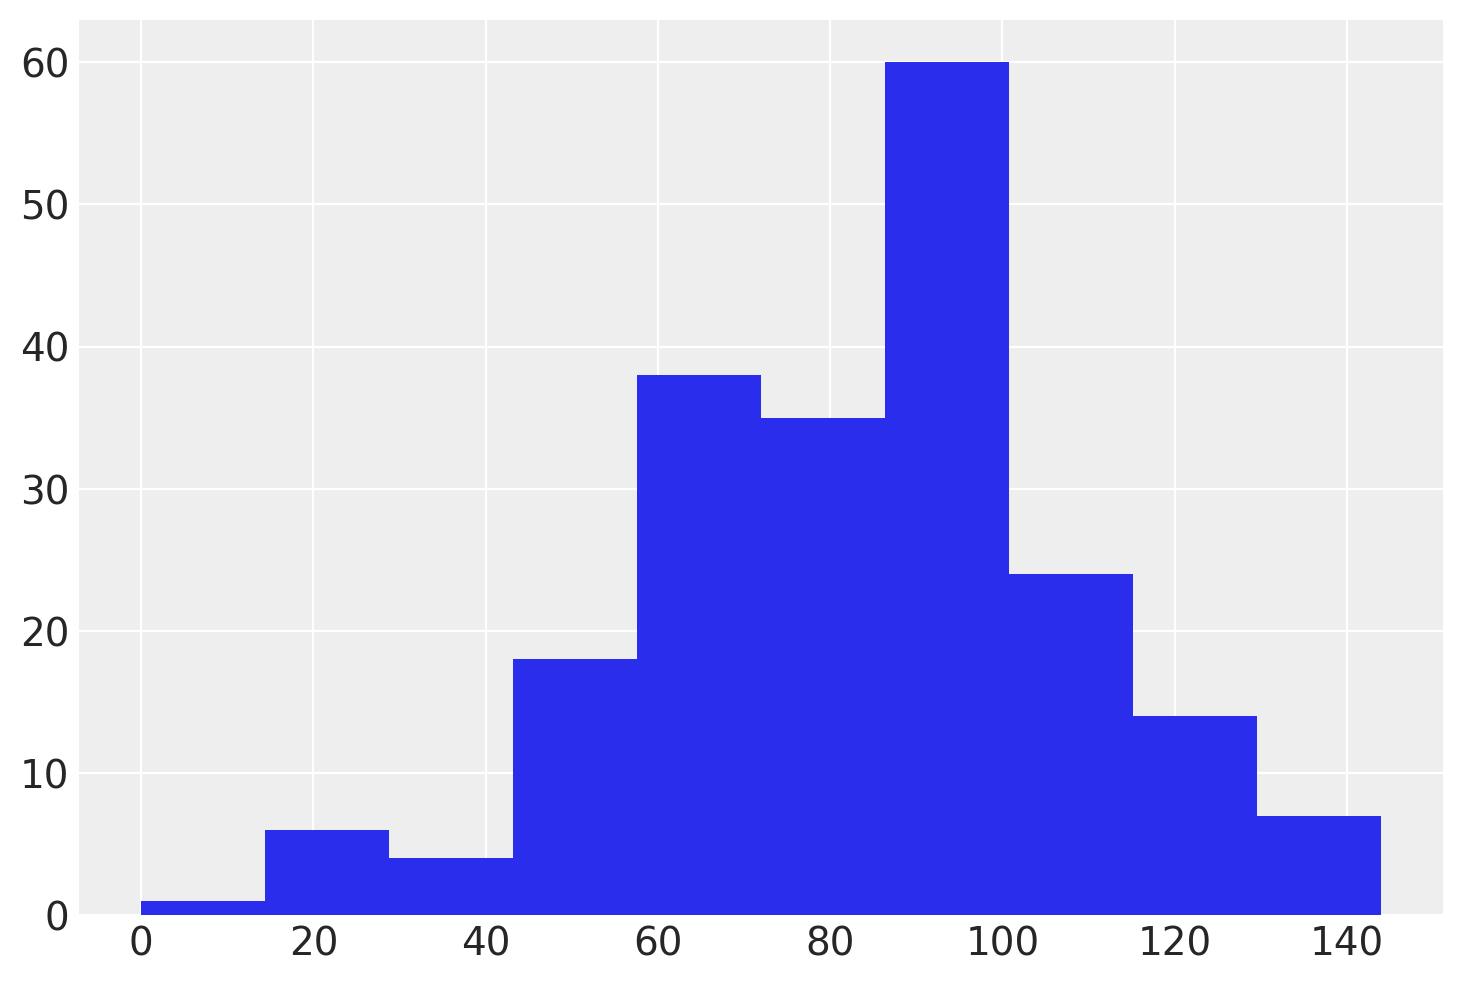

In [14]:
test_scores["score"].hist();

In [15]:
# Dropping missing values is a very bad idea in general, but we do so here for simplicity
X = test_scores.dropna().astype(float)
y = X.pop("score")

# Standardize the features
X -= X.mean()
X /= X.std()

N, D = X.shape

## The Model

This is a more realistic problem than the first regression example, as we are now dealing with a multivariate regression model. However, while there are several potential predictors in the LSL-DR dataset, it is difficult a priori to determine which ones are relevant for constructing an effective statistical model. There are a number of approaches for conducting variable selection, but a popular automated method is regularization, whereby ineffective covariates are shrunk towards zero via regularization (a form of penalization) if they do not contribute to predicting outcomes.

You may have heard of regularization from machine learning or classical statistics applications, where methods like the lasso or ridge regression shrink parameters towards zero by applying a penalty to the size of the regression parameters. In a Bayesian context, we apply an appropriate prior distribution to the regression coefficients. One such prior is the hierarchical regularized horseshoe, which uses two regularization strategies, one global and a set of local parameters, one for each coefficient. The key to making this work is by selecting a long-tailed distribution as the shrinkage priors, which allows some to be nonzero, while pushing the rest towards zero.

In [16]:
D0 = int(D / 2)

In [19]:
import pytensor.tensor as at

with pm.Model(coords={"predictors": X.columns.values}) as test_score_model:
    # Prior on error SD
    sigma = pm.HalfNormal("sigma", 25)

    # Global shrinkage prior
    tau = pm.HalfStudentT("tau", 2, D0 / (D - D0) * sigma / np.sqrt(N))
    # Local shrinkage prior
    lam = pm.HalfStudentT("lam", 5, dims="predictors")
    c2 = pm.InverseGamma("c2", 1, 1)
    z = pm.Normal("z", 0.0, 1.0, dims="predictors")
    # Shrunken coefficients
    beta = pm.Deterministic(
        "beta", z * tau * lam * at.sqrt(c2 / (c2 + tau**2 * lam**2)), dims="predictors"
    )
    # No shrinkage on intercept
    beta0 = pm.Normal("beta0", 100, 25.0)

    scores = pm.Normal("scores", beta0 + at.dot(X.values, beta), sigma, observed=y.values)

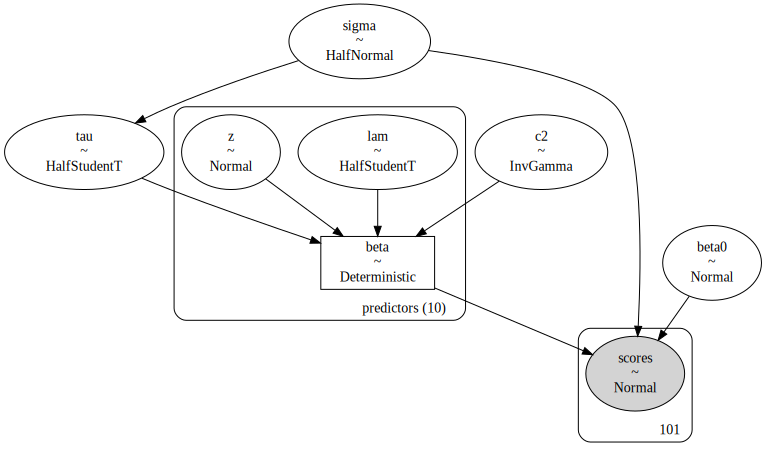

In [20]:
pm.model_to_graphviz(test_score_model)

Before we proceed further, let’s see what the model does before it sees any data. We can conduct prior predictive sampling to generate simulated data from the model. Then, let’s compare these simulations to the actual test scores in the dataset.

In [21]:
with test_score_model:
    prior_samples = pm.sample_prior_predictive(100)

Sampling: [beta0, c2, lam, scores, sigma, tau, z]


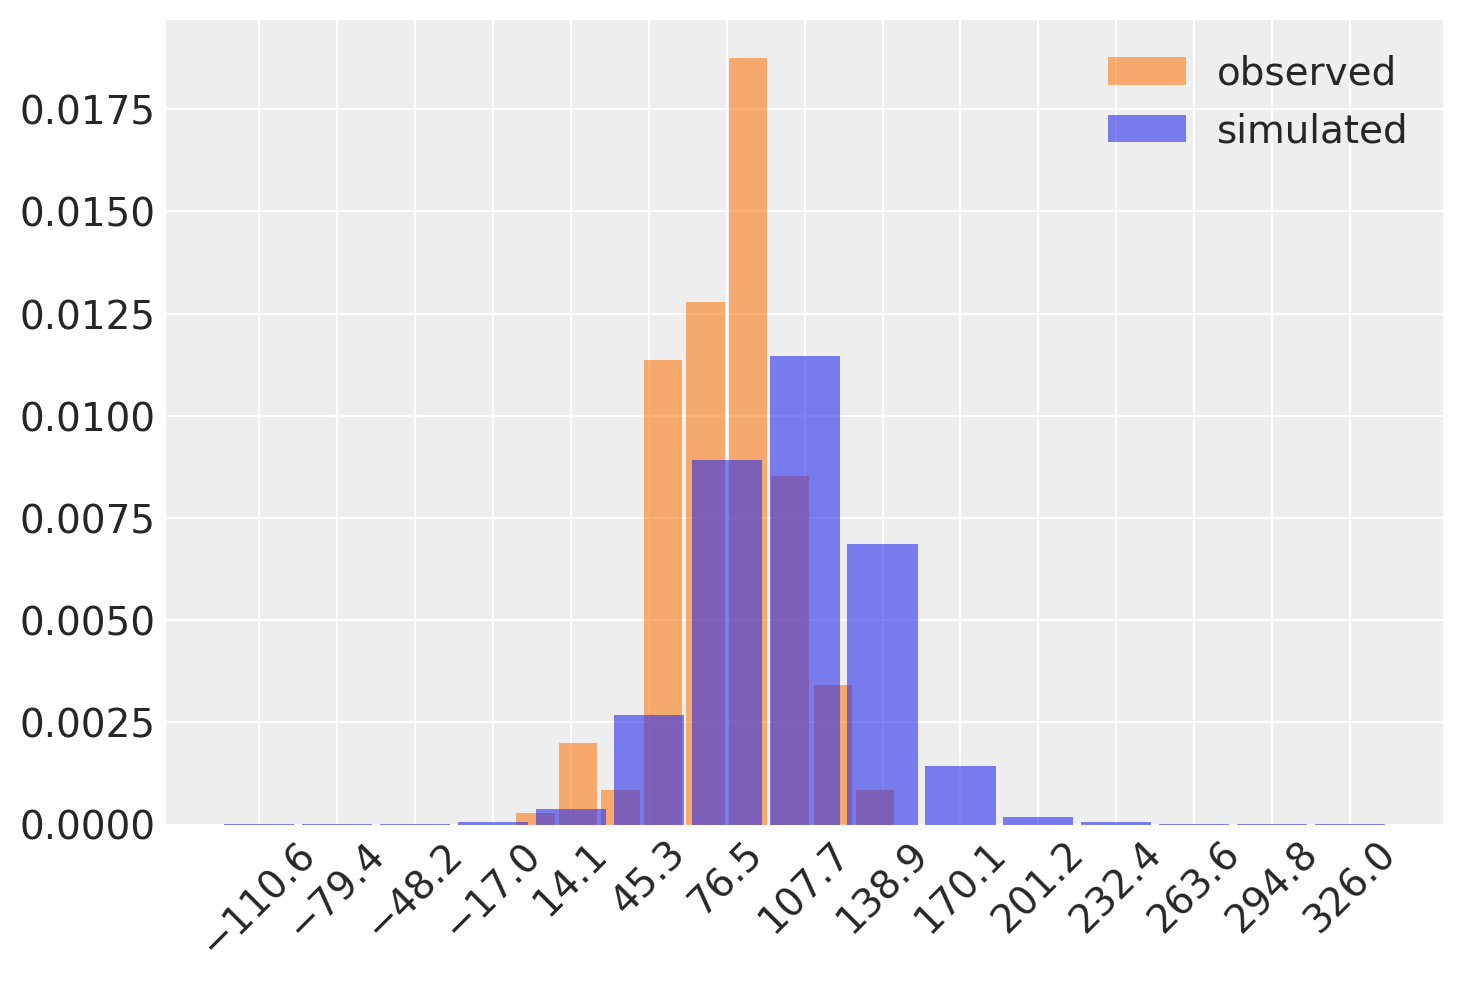

In [22]:
az.plot_dist(
    test_scores["score"].values,
    kind="hist",
    color="C1",
    hist_kwargs=dict(alpha=0.6),
    label="observed",
)
az.plot_dist(
    prior_samples.prior_predictive["scores"],
    kind="hist",
    hist_kwargs=dict(alpha=0.6),
    label="simulated",
)
plt.xticks(rotation=45);

How do we know if this is reasonable or not? This requires some domain knowledge of the problem. Here, we are trying to predict the outcomes of test scores. If our model was predicting values in the thousands, or lots of negative values, while excluding scores that are plausible, then we have misspecified our model. You can see here that the support of the distribution of simulated data completely overlaps the support of the observed distribution of scores; this is a good sign! There are a few negative values and a few that are probably too large to be plausible, but nothing to worry about.

## Model Fitting

Now for the easy part: PyMC’s “Inference Button” is the call to sample. We will let this model tune for a little longer than the default value (1000 iterations). This gives the NUTS sampler a little more time to tune itself adequately.

In [23]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 10 seconds.
There were 2 divergences after tuning. Increase `target_accept` or reparameterize.


Notice that we have a few warnings here about divergences. These are samples where NUTS was not able to make a valid move across the posterior distribution, so the resulting points are probably not representative samples from the posterior. There aren’t many in this example, so it’s nothing to worry about, but let’s go ahead and follow the advice and increase target_accept from its default value of 0.9 to 0.99.

In [24]:
with test_score_model:
    idata = pm.sample(1000, tune=2000, random_seed=42, target_accept=0.99)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [sigma, tau, lam, c2, z, beta0]


Output()

Sampling 4 chains for 2_000 tune and 1_000 draw iterations (8_000 + 4_000 draws total) took 26 seconds.


Since the target acceptance rate is larger, the algorithm is being more conservative with its leapfrog steps, making them smaller. The price we pay for this is that each sample takes longer to complete. However, the warnings are now gone, and we have a clean posterior sample!

## Model Checking

A simple first step in model checking is to visually inspect our samples by looking at the traceplot for the univariate latent parameters to check for obvious problems. These names can be passed to plot_trace in the var_names argument.

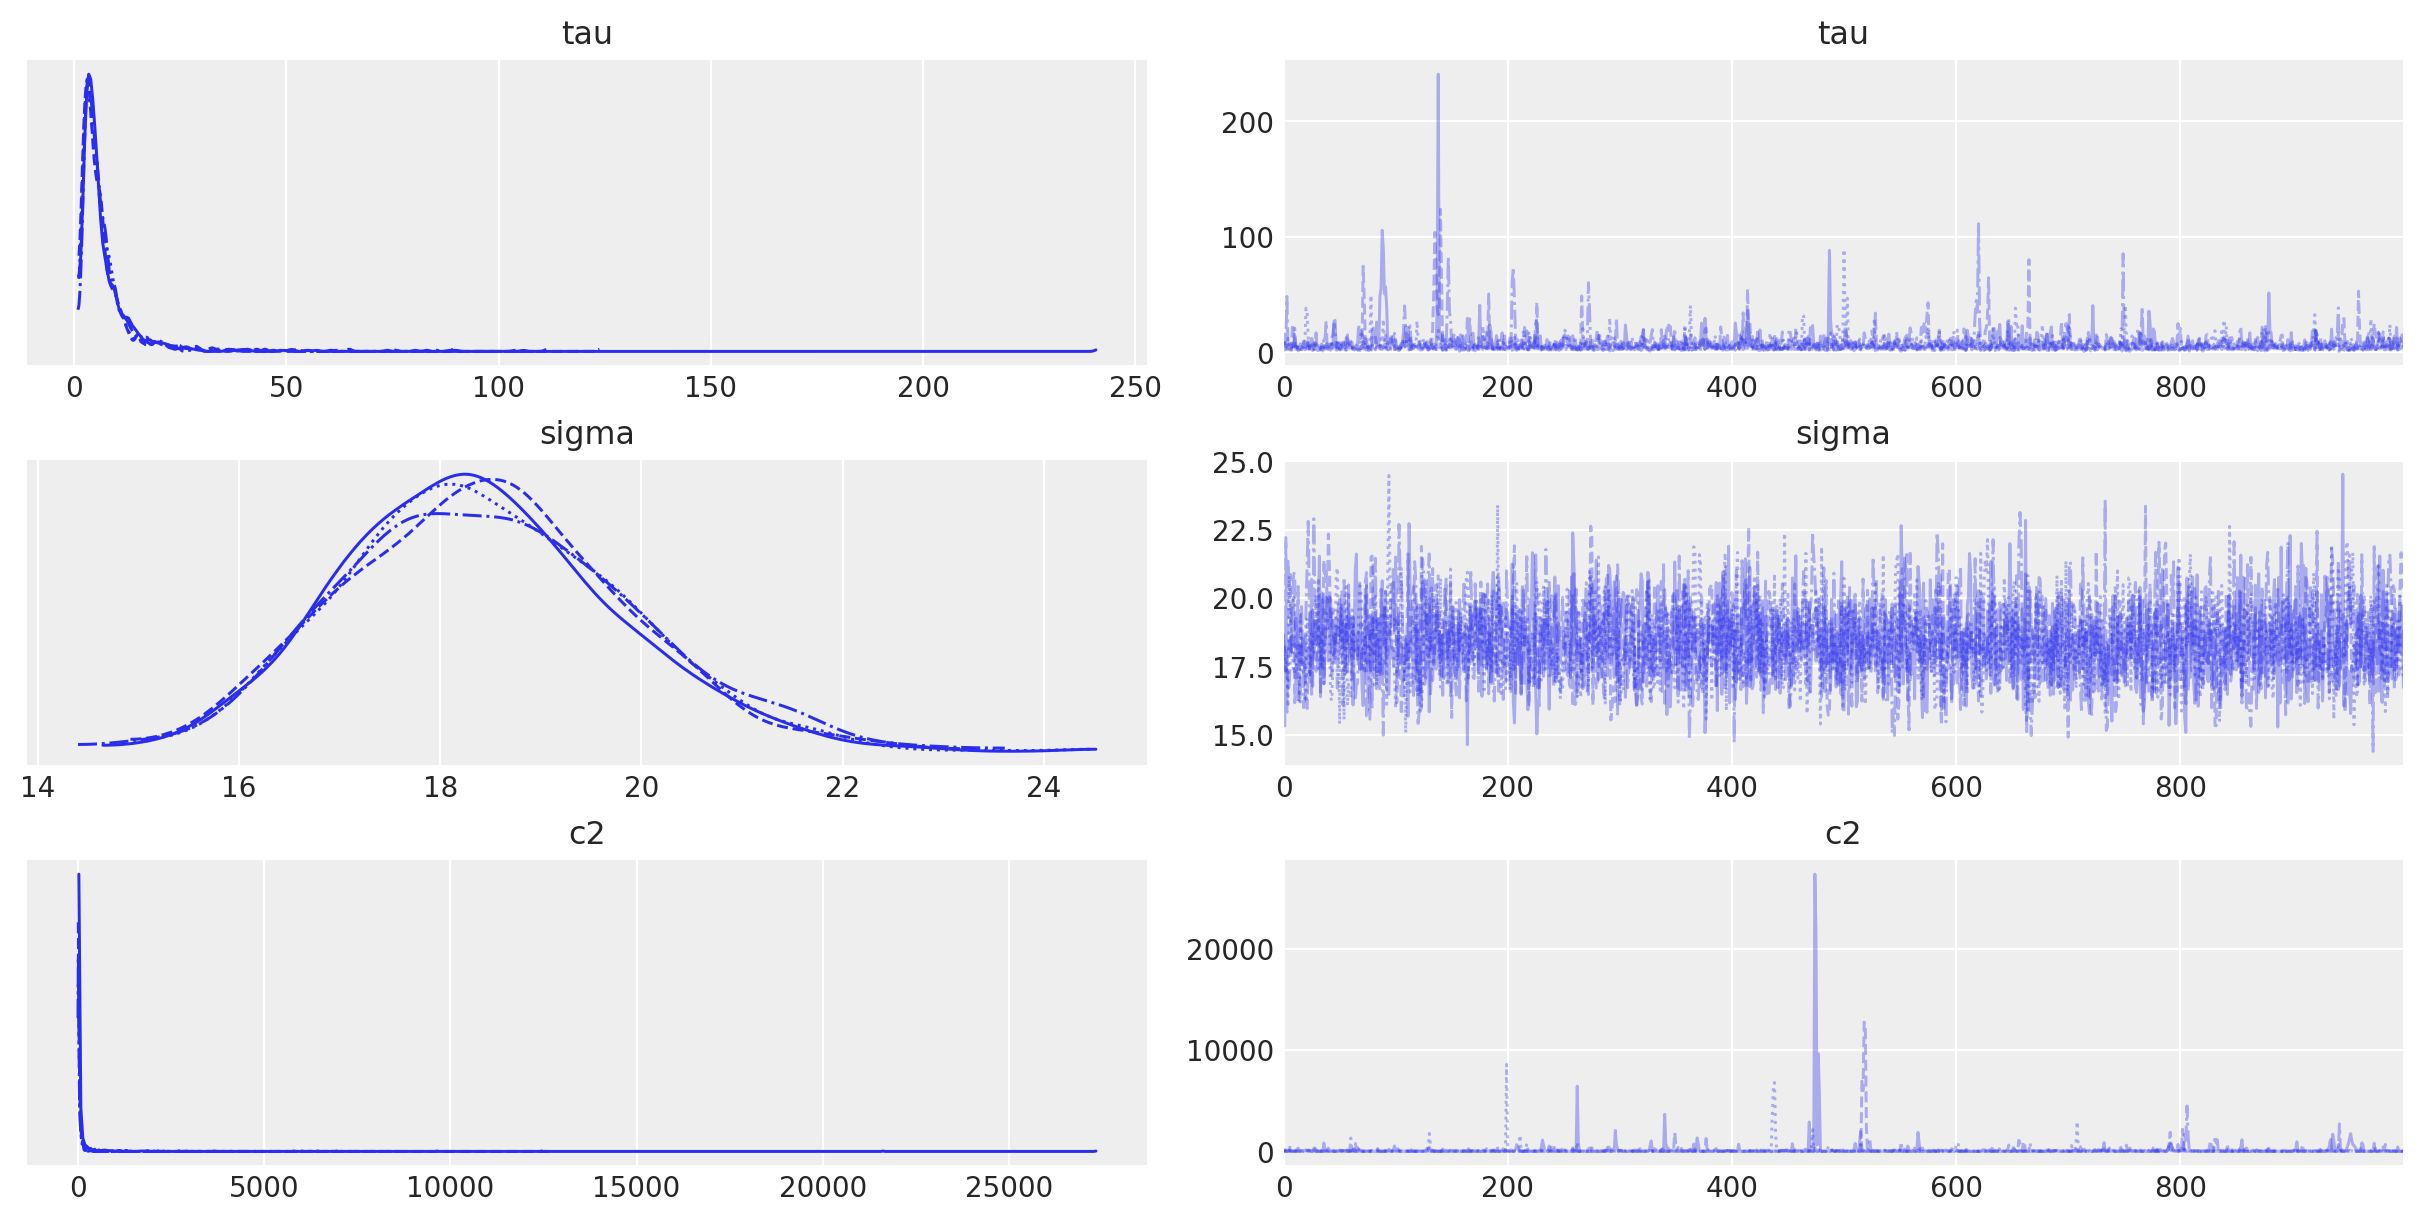

In [25]:
az.plot_trace(idata, var_names=["tau", "sigma", "c2"]);

Do these look okay? Well, each of the densities on the left side for each parameter look pretty similar to the others, which means they have converged to the same posterior distribution (be it the correct one or not). The homogeneity of the trace plots on the right are also a good sign; there is no trend or pattern to the time series of sampled values. Note that c2 and tau occasionally sample extreme values, but this is expected from heavy-tailed distributions.

The next easy model-checking step is to see if the NUTS sampler performed as expected. An energy plot is a way of checking if the NUTS algorithm was able to adequately explore the posterior distribution. If it was not, one runs the risk of biased posterior estimates when parts of the posterior are not visited with adequate frequency. The plot shows two density estimates: one is the marginal energy distribution of the sampling run and the other is the distribution of the energy transitions between steps. This is all a little abstract, but all we are looking for is for the distributions to be similar to one another. Ours does not look too bad.

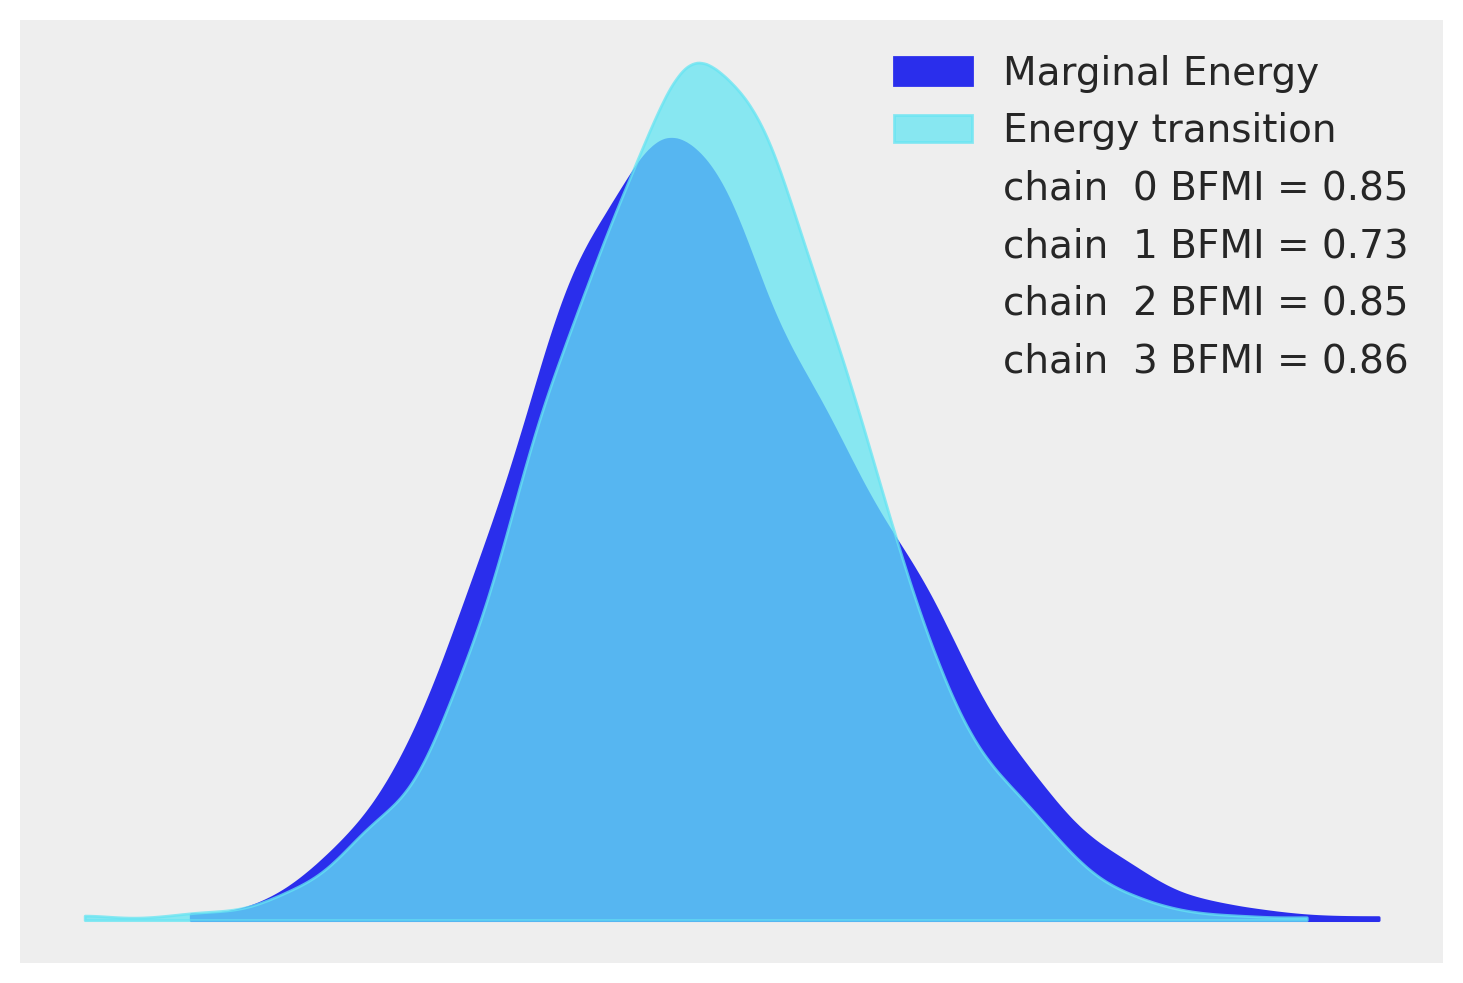

In [26]:
az.plot_energy(idata);

Ultimately, we are interested in the estimates of beta, the set of predictor coefficients. Passing beta to plot_trace would generate a very crowded plot, so we will use plot_forest instead, which is designed to handle vector-valued parameters.

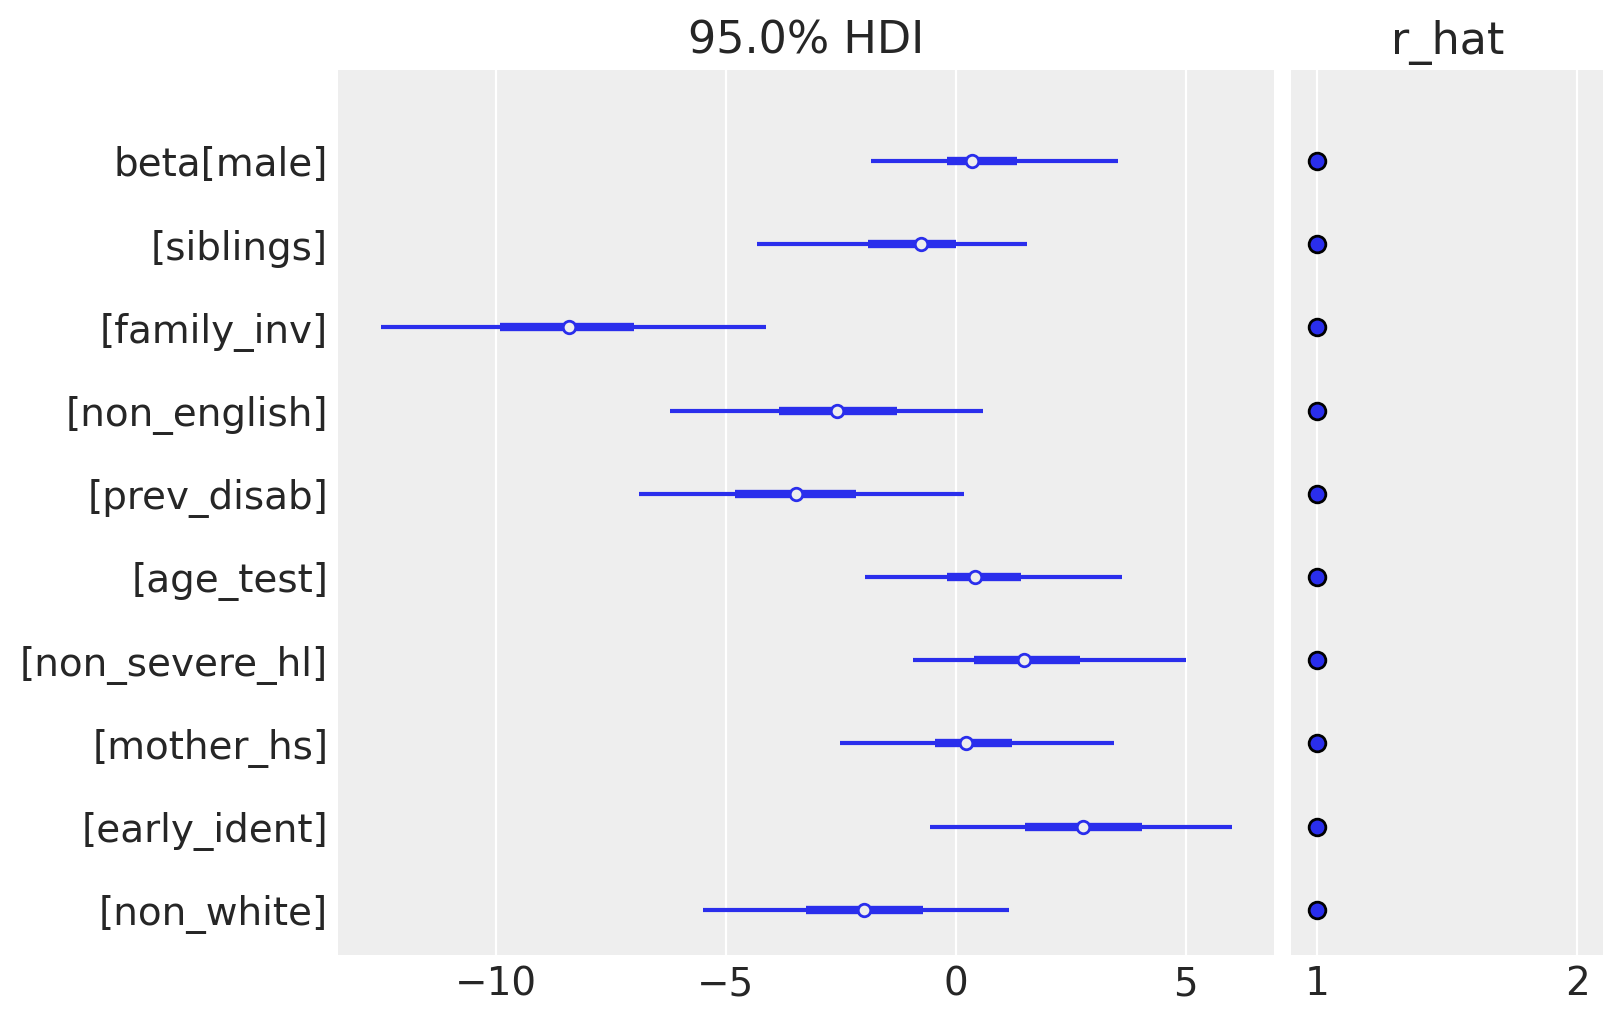

In [27]:
az.plot_forest(idata, var_names=["beta"], combined=True, hdi_prob=0.95, r_hat=True);

The posterior distribution of coefficients reveal some factors that appear to be important in predicting test scores. Family involvement (family_inv) is large and negative, meaning a larger score (which is related to poorer involvement) results in much worse test scores. On the other end, early identification of hearing impairment is positive, meaning that detecting a problem early results in better educational outcomes down the road, which is also intuitive. Notice that other variables, notably gender (male), age at testing (age_test), and the mother’s educational status (mother_hs) have all been shrunk essentially to zero.